<a href="https://colab.research.google.com/github/aaron-ruhl/Renewind/blob/main/MT_Project_LearnerNotebook_FullCodeAaronRuhl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main

## Problem Statement

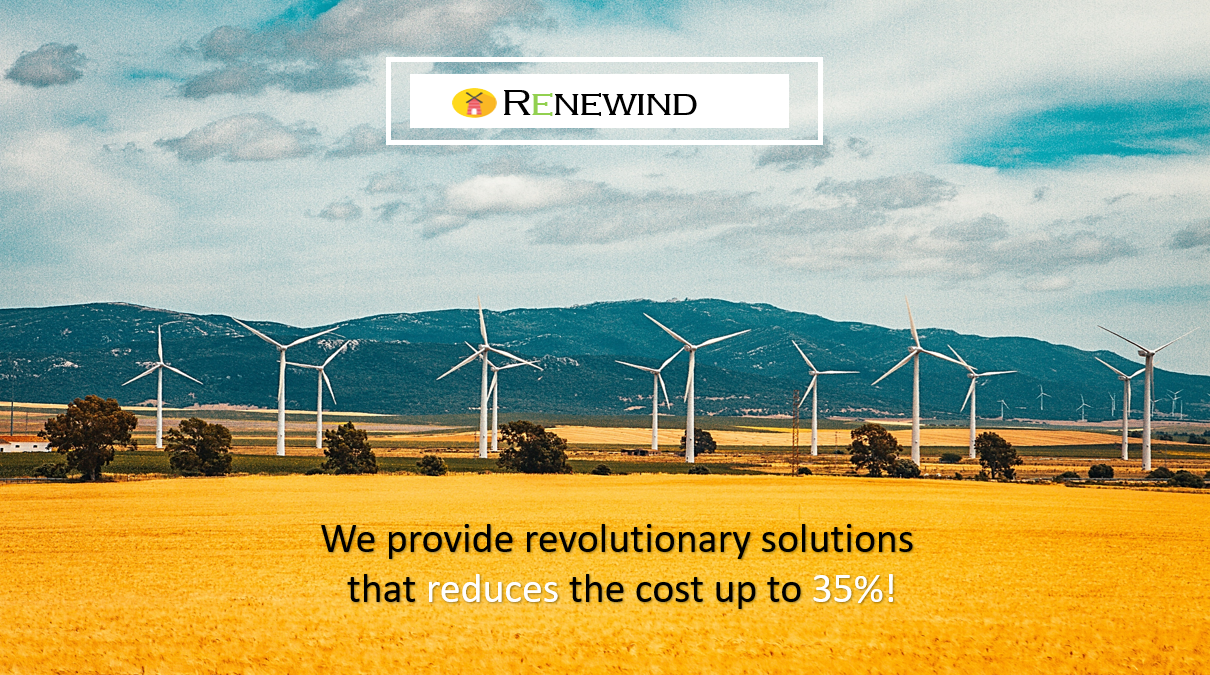

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
#importing standard python libraries for working with numbers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#incase I decide to make diagnostic plots of skewed distributions
import scipy.stats as stats

#sklearn libraries for data pre-processing
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import metrics

#sklearn libraries for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#sklearn library used for hypertuning
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Using my preferred method to read in files on google.colab
from google.colab import files
uploaded=files.upload()

In [ ]:
import io
data=pd.read_csv(io.BytesIO(uploaded["Train.csv"]))
data.head()

## Data Overview

In [ ]:
data.head()

In [ ]:
data.tail()

### *Splitting up pd.describe()...and adding range*

In [ ]:
# data.describe().T # This becomes very cumbersome to analyze, so I decided to split it up into four seperate parts, {[V1-V10],[V11-V20],[V21-V30],[V31-V40]}

In [ ]:
a=0
b=10

print('Range V{}-V{}: \n{} \n'.format(a+1,b,(data.iloc[:,a:b].max())-(data.iloc[:,a:b].min())),
      sep=''
      )

data.iloc[:,a:b].describe().T

In [ ]:
a=10
b=20

print('Range V{}-V{}: \n{} \n'.format(a+1,b,(data.iloc[:,a:b].max())-(data.iloc[:,a:b].min())),
      sep=''
      )

data.iloc[:,a:b].describe().T

In [ ]:
a=20
b=30

print('Range V{}-V{}: \n{} \n'.format(a+1,b,(data.iloc[:,a:b].max())-(data.iloc[:,a:b].min())),
      sep=''
      )

data.iloc[:,a:b].describe().T

In [ ]:
a=30
b=40

print('Range V{}-V{}: \n{} \n'.format(a+1,b,(data.iloc[:,a:b].max())-(data.iloc[:,a:b].min())),
      sep=''
      )

data.iloc[:,a:b].describe().T

Average Range & Standard Deviation(std):

In [ ]:
#Calculating the average range of these variables
range_sum = 0

for a,b in [[0,10],[10,20],[20,30],[30,40]]:
  range_sum += (data.iloc[:,a:b].max()-data.iloc[:,a:b].min()).sum()
avg_range=range_sum/40
avg_range

In [ ]:
#Calculating the average std of these variables
std_sum = 0

for a,b in [[0,10],[10,20],[20,30],[30,40]]:
  std_sum += (data.iloc[:,a:b].std()).sum()
avg_std=std_sum/40
avg_std

*Observations:*

- Okay, appears to be 40 continuous variables. All variables(V1-V40) include zero with negative minimums and positive maximums.
  - Note, I am referring to all the charts above here in one section for sake of efficiency.

- Mean observation of each variable is quite diverse.
  - Includes negative and positive values; some expected values are much larger in magnitude.
  - For instance the mean of `V37` is almost zero at -0.011316 and `V3` has a mean of 2.484699, which is positive and much larger in magnitude.

- Range of these variables is \~26 on average, but, again I see quite diverse ranges overall, similar to the situation with the mean values.
  - For example, range of `V39`(\~14) and `V32`(\~43)

- Std of \~3.04 on average with some variables below and above this value. However only by a significant, but not far from ordinary amount such as +/- 1 or 2.
  - Essentially, std appears to be the only parameter that is relatively constant, which is probably due to some scaling that has been applied to this dataset.
  - `V32` has a large std of \~5.5 that is much bigger than the other variables.
  - Some have std less than 2 such as `V22` & `V37`, but never below 1.5.


In [ ]:
data.info()

In [ ]:
data.isna().sum().head()

In [ ]:
data.duplicated().sum()

*Observation:*
- Continuous float values that do not need to be transformed anmymore than they alreay have been.
  - I should convert `Target` from int64 to a float for use in sklearn.
- 18 missing observations in the `V1` & `V2` columns. These will need to be imputed.

In [ ]:
data.Target.value_counts(1)

**Observation**
- A very imbalanced data set with only around 5.55% of the data recorded as the `Target` class.

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False,bins=None,hue=None,color=None,palette=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_box3, ax_hist2) = plt.subplots(
        nrows=3,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.20, 0.20, 0.60)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color='RebeccaPurple'
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.boxplot(
        data=data, x=feature, y=data["Target"], ax=ax_box3, showmeans=True, palette=palette, orient="h"
    )
    sns.histplot(
        data=data, x=feature, kde=kde, hue=hue, ax=ax_hist2, bins=bins, palette=palette
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
for feature in data.columns:
    histogram_boxplot(data, feature, figsize=(12, 7),kde=True,bins=50,hue='Target',palette='pastel')

*Observations:*
- Variables are all roughly normally distributed.
- Some of the features do not seem to distinguish between minority/majority class well on their own. On the other hand, other variables appear to be reasonably strong predictors of failures.
- Large amount of outliers, these may not be significant outliers that can be removed for a better prediction. However some models do not care about outliers and I alrgely ignored this option in this project.



**I looked at the IQR of each variables target boxplot(orange). And checked it majority class's boxplot(light blue). If target IQR did not contain *both* mean and median, then I included it below as a significant factor:**
- [`V1`:`V10`] -> `V3`,`V7`, & `V8`
- [`V11`:`V20`] -> `V11`, `V15`, `V16`, & `V18`
- [`V21`:`V30`] -> `V21`, `V26`, & `V28`
- [`V31`:`V40`] -> `V34` is pretty close,`V36` & `V39`

**Similarily, I decided the variables that looked fairly constant between the majority and minority class, note some variables are in-between and not included in either list**
- [`V1`:`V10`] -> `V2`,`V6`, & `V9`
- [`V11`:`V20`] -> `V12`
- [`V21`:`V30`] -> `V25`,`V27`, & `V30`
- [`V31`:`V40`] -> `V37`,`V38` is pretty close, & `V40`

**Let's see if we can filter for these variables by evaluating difference between majority and minority class median and mean.**

In [ ]:
significant_variables=[]

for feature in data.columns:

  check1=data.groupby(["Target"])[feature].median()
  if np.abs(check1[0] - check1[1]) > data[feature].std():
    significant_variables.append(feature)
    continue

  check2=data.groupby(["Target"])[feature].mean()
  if np.abs(check2[0] - check2[1]) > data[feature].std():
    significant_variables.append(feature)

print("{} significant variables detected: {}".format(len(significant_variables),significant_variables[:-1]),)

significant_variables=significant_variables[:-1]

*Observations*
- By checking for differences between median and means of majority/minority within each sub-class, `V7`,`V15`,`V16`,`V18`,`V21`,`V36`, and `V39` were detected as significant variables. Which, compared to the graphs above, is a fair assumption.
- Overall, without considering interactions with other variables, these appear to have a high chance of being significant features in the model.

**What about the constant features, can I filter for those aswell?**

In [ ]:
constant_variables=[]

for feature in data.columns:


  check1=data.groupby(["Target"])[feature].median()
  if np.abs(check1[0] - check1[1]) < data[feature].median()/data[feature].std():
    constant_variables.append(feature)
    continue

  check2=data.groupby(["Target"])[feature].mean()
  if np.abs(check2[0] - check2[1]) < data[feature].mean()/data[feature].std():
    constant_variables.append(feature)



print("{} constant variables detected: {}".format(len(constant_variables),constant_variables),)

*Observations:*
- Appears that only `V2`, `V12`, & `V30` were detected as the most constant filters for the `Target` class in this data when checked against median/mean divided by std (scaled data).
- This seems to be a fair call to make based on the graphs above.
- Also I should note that it is quite interesting how many that appeared constant, are not considered constant based on this test. The graphs make them look pretty close, but this test appears to be more strict that just looking visually.

### Let's examine a boxplot graph of these variables

In [ ]:
plt.figure(figsize=(20,7))
sns.boxplot(data=data.iloc[:,:-1],showmeans=True)
plt.title("Range of variables: V1-V40")
plt.xlabel("Variables V1-V40")
plt.ylabel("Transformed Observations");

*Observations*
- Shows the diversity of the data quite well.
- `V2` & `V12` have a similar distribution and they were both tagged as insignificant.
  - However so does `V13`,`V26`, and `V35`, which were not insignificant.
- There is other similarities such as `V39` & `V37`. The former I guessed was significant, and it was, while the latter appeared insignificant in the graphs. Also `V16` and `V36` are both significant, as indicated above, but with means that are opposite in sign and similar overall spreads.


### Lets examine some possible relationships between the variables

In [ ]:
sns.set(rc={'figure.figsize':(23,18)})
sns.heatmap(data.iloc[:,:39].corr(),
            linewidths=.5,
            center=0,
            cmap="Spectral")
plt.show()

*Observation*
- Appears to be significant correlation within this data. I understand that it is data collected from sensors of wind-powered generators. Thus, it may not be out of the ordinary to see such correlation.
- This could also be a result of the transformation this data has undergone.

## Data Pre-processing

In [ ]:
X=data.drop('Target',axis=1)
y=data['Target'].astype(float)

In [ ]:
uploadedTest = files.upload()
testData=pd.read_csv(io.BytesIO(uploadedTest['Test.csv']))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=10,stratify=y)
X_train.shape, X_val.shape

X_test = testData.drop('Target',axis=1)
y_test = testData.Target

In [ ]:
X_train.shape,X_val.shape,X_test.shape

## Missing value imputation




In [ ]:
# Let's impute the missing values
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")

for x in ['V1','V2']:
# fit the imputer on train data and transform the train data
  X_train[x] = imp_median.fit_transform(X_train[[x]])

# transform the validation and test data using the imputer fit on train data
  X_val[x] = imp_median.transform(X_val[[x]])
  X_test[x] = imp_median.transform(X_test[[x]])

In [ ]:
print('Original data missing:\n',data.isna().sum().head(),
      '\n\nX_train missing:\n',X_train.isna().sum().head(),
      '\n\nX_val missing:\n',X_val.isna().sum().head(),
      '\n\nX_test missing:\n',X_test.isna().sum().head(),sep='')

*Observation:*
- SimpleImputer worked as expected.

## X_train EDA

**Lets make an X_train copy with y_train attached to see pairplots of X_train with `Target` hue**

In [ ]:
#making X_train_eda for graphical analysis of relationship towards target
X_train_eda = X_train.join(y_train)
X_train_eda

In [ ]:
X_train

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# let's check the VIF of the predictors
vif_series = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
    dtype=float,
)
print("VIF values: \n\n{}\n".format(vif_series))

*Observation:*
- Appears to be alot of multicolinearity based on this test and the correlation matrix shown previously.
- Again the data is heavily transformed so this massive multicolinearity might be more of an illusion than anything. I decided to leave it alone in this project for simplicity.
- Interestingly, as an aside, the two variables that were imputed have significantly lower VIF values (V1,V2). Not sure if that is significant or just a coincidence.


### Checking for interactions amongst "significant" variables

In [ ]:
g=sns.pairplot(
            X_train_eda,
            hue = "Target",
            kind="hist",
            palette="pastel",
            x_vars = X_train_eda[significant_variables].columns,
            y_vars = X_train_eda.drop(significant_variables,axis=1).columns[:-1]
            )
g.map(sns.kdeplot, palette="crest");

*Observations:*
- `V7`
  - `V35` appears to make a decent sharp point when compared against `V7`. Alot of scatter aswell. Overall, not many strong interactions when compared against these "non-significant" variables. By "non-significant" I simply mean not included in the list I defined above, so 32 variables are "non-significant".
- `V15`
  - Appears to follow a very similar trend, `V35` is best interaction by far, but nothing really stands out as being an excellent interaction for distinguishing `Target` (orange dots).
- `V16`
  - Slightly better interactions than the last two variables, especially in the 30s
  - Also notice how each variable interacts with the others differently depending on which second variable was selected. Not extremely large seperation here, but they do show significant within-class differences between these interactions. Some are scattered such as `V16` & `V37`and others can be more linear like `V16` & `V8`.
- `V18`
  - Wow this one appears to be doing a great job of distinguishing the `Target`. All the interactions are decent but they could certainly be sharper distinctions. Maybe the interactions against significant variables will show this increased sharpness.
  - Note, again `V18` shows this within-class variance in how it interacts with other variables depending on which variable it was compared against.
- `V21`
  - similar pattern to `V18`, `V21`&`V18` have been the best so far.
- `V36`
  - Wow, this one has very sharp points indeed. It was able to distinguish sharp boundaries amongst interactions with these "non-significant" variables.
  - Notice that some of the interactions are almost columnar in shape.
    - Essentially only limited ranges of `V36` contained the target class. Comparing it to certain variables magnified this distinction.
- `V39`
  - Some sharp boundaries aswell such as `V39`&`V38`
  - Overall, weaker distinctions compared to `V36`.


In [ ]:
g=sns.pairplot(
            X_train_eda,
            hue = "Target",
            diag_kind = "auto",
            kind="hist",
            palette="pastel",
            x_vars = X_train_eda[significant_variables].columns,
            y_vars = X_train_eda[significant_variables].columns
            )
g.map_offdiag(sns.kdeplot, palette="crest");

- Not much additional to say here except that stronger interactions across the board when looking amongst "significant" variables only. Basically im noticing more instances of good seperation without too much spread of the target class, such as `V16`&`V36`.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,X_test=X_test,labels=[1, 0]): #I exposed X_test in the function definition so I can switch it to X_val if needed
    '''
    model : classifier to predict values of X
    y_actual : ground truth

    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
from sklearn import metrics
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with Original data

In [ ]:
'''
Setting up the models list
'''
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("naive_bayes", GaussianNB()))
models.append(("qda", QuadraticDiscriminantAnalysis()))
models.append(("lda", LinearDiscriminantAnalysis(solver="lsqr")))
models.append(("dtree", DecisionTreeClassifier(random_state=7)))
models.append(("logit", LogisticRegression(random_state=7)))
models.append(("random_forest", RandomForestClassifier(random_state=7)))
models.append(("adaboost", AdaBoostClassifier(random_state=7)))
models.append(("xgboost", XGBClassifier(random_state=7)))
models.append(("bagging", BaggingClassifier(random_state=7)))

In [ ]:
results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models



n_splits=5 # Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset, {} splits & length of {}...\n".format(n_splits,len(X_train)))

# loop through all models to get the mean cross validated score
for name, model in models:
    kfold = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
#making a DataFrame of the results for graphing
results_plot=(pd.DataFrame(results,columns=["fold1","fold2","fold3","fold4","fold5"],index=names)).T

print(results_plot,'\n\nMean cross-validation scores...\n\n',
      results_plot.mean(),sep='')

print("\n" "checking performance against `X_val` dataset...")


scores = []

# loop through all models to get the validation data score
for name, model in models:
    model.fit(X_train, y_train)
    score = metrics.recall_score(y_val, model.predict(X_val))
    scores.append(score)

results_val_plot = pd.DataFrame(scores,index=names,columns=["recall"])
results_val_plot #making a DataFrame of the results for graphing

In [ ]:
plt.figure(figsize=(10,7))
ax=sns.boxplot(data=results_plot.iloc[:,:3],showmeans=True)
plt.title("Recall scores for discriminant analysis")
plt.ylabel("recall");

*Observation*
- Discriminant Analysis is shown simply for comparison.
- In fact, if you make a confusion matrix of QDA it actually is a pretty bad model, just has incredibly good recall.
  - I left out tuning QDA because I have never been taught how to properly use this model. I just know the mathematics behind these models allows great comparisons to be made.

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot.iloc[:,3:],showmeans=True)
plt.title("Recall scores for non-linear models")
plt.ylabel("recall");

In [ ]:
sns.barplot(data=results_val_plot,x=results_val_plot["recall"],
            y=results_val_plot.index)
plt.yticks(rotation=45)
plt.title("Test of models against `X_val` dataset");

*Observations:*
- All of these models are performing about the same as Naive-Bayes in terms of recall.
  - This result indicates the interactions between the variables is not being captured properly by these models.
  - For example, the LDA and logit performance are both much lower and they do not inherently include the ability to capture the diverse interactions without including interaction terms explicityl.

**Let's try using randomly over-sampled data instead**




### Model Building with Oversampled data


In [ ]:
from imblearn.over_sampling import SMOTE
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
print('Original y_train:\n{}\nNew y_train_over: \n{}'.format(y_train.value_counts(1),y_train_over.value_counts(1)),'\n',sep='')
X_train.shape,X_train_over.shape

In [ ]:

results_over = []  # Empty list to store all model's CV scores
names_over = []

n_splits=5# Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset, {} splits & length of {}...\n".format(n_splits,len(X_train_over)))

# loop through all models to get the mean cross validated score
for name, model in models:
    kfold = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)

#making a DataFrame of the results for graphing
results_plot_over=(pd.DataFrame(results_over,columns=["fold1","fold2","fold3","fold4","fold5"],index=names_over)).T

print(results_plot_over,'\n\nMean cross-validation scores...\n\n',
      results_plot_over.mean(),sep='')

print("\n" "checking performance against `X_val` dataset...")

scores=[]

# loop through all models to get the validation data score
for name, model in models:
    model.fit(X_train_over, y_train_over)
    score = metrics.recall_score(y_val, model.predict(X_val))
    scores.append(score)

results_val_plot_over = pd.DataFrame(scores,index=names_over,columns=["recall"])
results_val_plot_over #making a DataFrame of the results for graphing

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_over.iloc[:,:3],showmeans=True)
plt.title("Recall scores for Discriminant Analysis")
plt.ylabel("recall");

*Observations:*
- Similar results to the original data here, but if you look closely QDA's overfitting appears to have very slightly imporoved.
  - Perhaps an increased amount of observations in the data due to the up sampling has caused this improvement. Also LDA improved substantially possibly as a result of more observations.

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_over.iloc[:,3:],showmeans=True)
plt.title("Recall scores for non-linear models")
plt.ylabel("recall");

In [ ]:
sns.barplot(data=results_val_plot_over,x=results_val_plot_over["recall"],
            y=results_val_plot_over.index)
plt.yticks(rotation=45)
plt.title("Test of models against `X_val` dataset");

*Observations:*
- Now we can see that the decision tree, bagging, and random_forest are able to capture these interactions due to the nature of splitting into trees; performing more like QDA.
- Unfortunately, all these models are overfitting considerably. Perhaps there is just too much noise in this over sampled data to capture the important interactions highlighted by EDA.

**Let's Try using randomly under-sampled data**

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)
print('Original y_train:\n {}\nNew y_train_un: \n{}'.format(y_train.value_counts(1),y_train_un.value_counts(1)),'\n',sep='')
X_train.shape,X_train_un.shape

In [ ]:
results_un = []  # Empty list to store all model's CV scores
names_un = []

n_splits=5# Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset, {} splits & length of {}...\n".format(n_splits,len(X_train_un)))

# loop through all models to get the mean cross validated score
for name, model in models:
    kfold = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_un.append(cv_result)
    names_un.append(name)

#making a DataFrame of the results for graphing
results_plot_un=(pd.DataFrame(results_un,columns=["fold1","fold2","fold3","fold4","fold5"],index=names_un)).T

print(results_plot_un,'\n\nMean cross-validation scores...\n',
      results_plot_un.mean(),sep='')

print("\n" "checking performance against `X_val` dataset...")

scores=[]

# loop through all models to get the validation data score
for name, model in models:
    model.fit(X_train_un, y_train_un)
    score = metrics.recall_score(y_val, model.predict(X_val))
    scores.append(score)

results_val_plot_un = pd.DataFrame(scores,index=names_un,columns=["recall"])
results_val_plot_un #making a DataFrame of the results for graphing

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_un.iloc[:,:3],showmeans=True)
plt.title("Recall scores for Discriminant Analysis")
plt.ylabel("recall");

*Observation:*
- Now QDA is underfitting compared to prior results as a resilt of only 1664 observations to train in the under-sampled data.

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_un.iloc[:,3:],showmeans=True)
plt.title("Recall scores for non-linear models")
plt.ylabel("recall");

In [ ]:
sns.barplot(data=results_val_plot_un,x=results_val_plot_un["recall"],
            y=results_val_plot_un.index)
plt.yticks(rotation=45)
plt.title("Test of models against `X_val` dataset");

*Observations:*
- Excellent, it looks like the overfitting problem has massivley reduced with under-sampled data.
- Random_forest, XGB, and Bagging Classifier built with randomly under sampled data appears to be the best picks so far. Adaboost is not far behind.

**I am going to now tune all these models with the sample parameter space found in Appendix B below, this allows me to compare the results without the added complication of also learning hyper-parameter tuning, which seems like it really just takes more experience**

## HyperparameterTuning

### Tuned with Original data

In [ ]:
models_tuned = []

`Decision Tree Tuning`

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)
best_params=randomized_cv.best_params_
models_tuned.append(("dtree_tuned_original", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Logistic Regression Tuning`

In [ ]:
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)
best_params=randomized_cv.best_params_
models_tuned.append(("logit_tuned_original", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\n\nBest parameters are {} with CV score={}:" .format(best_params,randomized_cv.best_score_))

`Random Forest Tuning`

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
              "max_features": ['auto','sqrt'],
              "max_samples": np.arange(0.4, 0.7, 0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1, verbose=2,error_score='raise')

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)
best_params=randomized_cv.best_params_
models_tuned.append(("random_forest_tuned_original", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`AdaBoost Tuning`

In [ ]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05],
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                 DecisionTreeClassifier(max_depth=2, random_state=1),
                                 DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)
best_params=randomized_cv.best_params_
models_tuned.append(("adaboost_tuned_original", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`XGBoost Tuning`

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
            'learning_rate': [0.1,0.2],
            'gamma': [0,3,5],
            'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)
best_params=randomized_cv.best_params_
models_tuned.append(("xgboost_tuned_original", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Bagging Classifier Tuning`

In [ ]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1],
              'max_features': [0.7,0.8,0.9],
              'n_estimators' : [30,50,70], }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1,verbose=2)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)
best_params=randomized_cv.best_params_
models_tuned.append(("bagging_tuned_original", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\n".format(best_params,randomized_cv.best_score_))

### Tuned with Oversampled data

In [ ]:
models_tuned_over = []

`Decision Tree Tuning`

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)
best_params=randomized_cv.best_params_
models_tuned_over.append(("dtree_tuned_over", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Logistic Regression Tuning`

In [ ]:
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)
best_params=randomized_cv.best_params_
models_tuned_over.append(("logit_tuned_over", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {} with CV score={}:" .format(best_params,randomized_cv.best_score_))

`Random Forest Classifier Tuning`

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
              "max_features": ['auto','sqrt'],
              "max_samples": np.arange(0.4, 0.7, 0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1,verbose=2)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)
best_params=randomized_cv.best_params_
models_tuned_over.append(("random_forest_tuned_over", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Adaboost Tuning`

In [ ]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05],
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                 DecisionTreeClassifier(max_depth=2, random_state=1),
                                 DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)
best_params=randomized_cv.best_params_
models_tuned_over.append(("adaboost_tuned_over", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`XGB Tuning`

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
            'learning_rate': [0.1,0.2],
            'gamma': [0,3,5],
            'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)
best_params=randomized_cv.best_params_
models_tuned_over.append(("xgboost_tuned_over", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Bagging Classifier Tuning`

In [ ]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1],
              'max_features': [0.7,0.8,0.9],
              'n_estimators' : [30,50,70], }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1,verbose=2)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)
best_params=randomized_cv.best_params_
models_tuned_over.append(("bagging_tuned_over", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\n".format(best_params,randomized_cv.best_score_))

### Tuned with Undersampled data

In [ ]:
models_tuned_un = []

`Decision Tree Tuning`

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)
best_params=randomized_cv.best_params_
models_tuned_un.append(("dtree_tuned_un", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Logistic Regression Tuning`

In [ ]:
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)
best_params=randomized_cv.best_params_
models_tuned_un.append(("logit_tuned_un", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {} with CV score={}:" .format(best_params,randomized_cv.best_score_))

`Random Forest Tuning`

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
              "max_features": ['auto','sqrt'],
              "max_samples": np.arange(0.4, 0.7, 0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1,verbose=2)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)
best_params=randomized_cv.best_params_
models_tuned_un.append(("random_forest_tuned_un", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Adaboost Tuning`

In [ ]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05],
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                 DecisionTreeClassifier(max_depth=2, random_state=1),
                                 DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)
best_params=randomized_cv.best_params_
models_tuned_un.append(("adaboost_tuned_un", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`XGB Tuning`

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
            'learning_rate': [0.1,0.2],
            'gamma': [0,3,5],
            'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)
best_params=randomized_cv.best_params_
models_tuned_un.append(("xgboost_tuned_un", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\nFeature Importances:\n{}".format(best_params,randomized_cv.best_score_,pd.DataFrame(randomized_cv.best_estimator_.feature_importances_,
                                                                                                                                     index=range(1,41,1),
                                                                                                                                     columns=['V1-V40']).sort_values(by='V1-V40',ascending=False).head(10)))

`Bagging Classifier Tuning`

In [ ]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1],
              'max_features': [0.7,0.8,0.9],
              'n_estimators' : [30,50,70], }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1,verbose=2)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)
best_params=randomized_cv.best_params_
models_tuned_un.append(("bagging_tuned_un", randomized_cv.best_estimator_))
print("Computed final model from CV of various random arrangements created in random grid search....\nBest parameters are {}\n ----& with CV score(Recall)={}\n".format(best_params,randomized_cv.best_score_))

*Observations:*
- Wow random grid search is amazing, good results in way less time. I chose to compare more models rather than obsess over hypertuning here. I find the comparisons really useful to help learn.

## Model performance comparison and choosing the final model

**I realize that was alot of tuning, do not worry I will get right to the results**

### Original data tuning results

In [ ]:
# I used the append method to make this list in hypertuning automatically, but I then copied it into this cell as a save point
'''
models_tuned = [
 ('dtree_tuned',
  DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10,
                         min_impurity_decrease=0.0001, min_samples_leaf=7,
                         random_state=1)),
 ('logit_tuned', LogisticRegression(C=0.1, random_state=1)),
 ('random_forest_tuned',
  RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                         random_state=1)),
 ('adaboost_tuned',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                           random_state=1),
                     learning_rate=0.2, n_estimators=200, random_state=1)),
 ('xgboost_tuned',
  XGBClassifier(n_estimators=250, random_state=1, scale_pos_weight=10,
                subsample=0.8)),
 ('bagging_tuned',
  BaggingClassifier(max_features=0.9, max_samples=0.8, n_estimators=70,
                    random_state=1))]
'''

In [ ]:
results_tuned = []  # Empty list to store all model's CV scores
names_tuned = []

n_splits=5 # Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset...{} splits".format(n_splits))

# loop through all models to get the mean cross validated score
for name, model in models_tuned:
    kfold = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results_tuned.append(cv_result)
    names_tuned.append(name)

#making a DataFrame of the results for graphing
results_plot_tuned=(pd.DataFrame(results_tuned,columns=["fold1","fold2","fold3","fold4","fold5"],index=names_tuned)).T

print(results_plot_tuned,'\n\nMean cross-validation scores...\n',
      results_plot_tuned.mean(),sep='')

print("\n" "checking performance against `X_val` dataset..." "\n")

scores=[]

# loop through all models to get the validation data score
for name, model in models_tuned:
    model.fit(X_train, y_train)
    score = metrics.recall_score(y_val, model.predict(X_val))
    scores.append(score)

results_val_plot_tuned = pd.DataFrame(scores,index=names_tuned,columns=["recall"])
results_val_plot_tuned#making a DataFrame of the results for graphing

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_tuned,showmeans=True)
plt.xticks(rotation=45)
plt.ylabel("Recall")
plt.title("Cross Validation Performance of tuned models with original dataset");

In [ ]:
sns.barplot(data=results_val_plot_tuned,x=results_val_plot_tuned["recall"],
            y=results_val_plot_tuned.index)
plt.yticks(rotation=45)
plt.title("Test of models against `X_val` dataset, tuned with original dataset");

**Observation:**
- Clearly on the original data, the XGB Classifier shines as the best option. Best overall score, least amount of overfit, and best generalization performance.

### Oversampled tuning results

In [ ]:
'''
models_tuned_over=[
 ('dtree_tuned_over', DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                         min_impurity_decrease=0.001, min_samples_leaf=7,
                         random_state=1)),
 ('logit_tuned_over', LogisticRegression(C=0.1, random_state=1)),
 ('random_forest_tuned_over',
  RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                         random_state=1)),
 ('adaboost_tuned_over',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                           random_state=1),
                     learning_rate=0.2, n_estimators=200, random_state=1)),
 ('xgboost_tuned_over',
  XGBClassifier(learning_rate=0.2, n_estimators=200, random_state=1,
                scale_pos_weight=10, subsample=0.9)),
 ('bagging_tuned_over',
  BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=70,
                    random_state=1))]
'''

In [ ]:

results_tuned_over = []  # Empty list to store all model's CV scores
names_tuned_over = []


n_splits=5 # Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset...{} splits".format(n_splits))

# loop through all models to get the mean cross validated score
for name, model in models_tuned_over:
    kfold = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_tuned_over.append(cv_result)
    names_tuned_over.append(name)

#making a DataFrame of the results for graphing
results_plot_tuned_over=(pd.DataFrame(results_tuned_over,columns=["fold1","fold2","fold3","fold4","fold5"],index=names_tuned_over)).T

print(results_plot_tuned_over,'\n\nMean cross-validation scores...\n',
      results_plot_tuned_over.mean(),sep='')

print("\n" "checking performance against `X_val` dataset..." "\n")

scores=[]
# loop through all models to get the validation data score
for name, model in models_tuned_over:
    model.fit(X_train_over, y_train_over)
    score = metrics.recall_score(y_val, model.predict(X_val))
    scores.append(score)

results_val_plot_tuned_over = pd.DataFrame(scores,index=names_tuned_over,columns=["recall"])
results_val_plot_tuned_over#making a DataFrame of the results for graphing

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_tuned_over,showmeans=True)
plt.xticks(rotation=45)
plt.ylabel("Recall")
plt.title("Cross Validation Performance of tuned models with oversampling");

In [ ]:
sns.barplot(data=results_val_plot_tuned_over,x=results_val_plot_tuned_over["recall"],
            y=results_val_plot_tuned_over.index)
plt.yticks(rotation=45)
plt.title("Test of models against `X_val` dataset, tuned with over sampling");

**Observation:**
- These models appear to be overfitting considerably. Let's see how the undersampled, tuned models performed.

### Undersampled tuning results

In [ ]:
'''
models_tuned_un=[
 ('dtree_tuned_un', DecisionTreeClassifier(max_depth=4, max_leaf_nodes=15,
                         min_impurity_decrease=0.001, random_state=1)),
 ('logit_tuned_un', LogisticRegression(C=0.1, random_state=1)),
 ('random_forest_tuned_un',
  RandomForestClassifier(max_samples=0.4, n_estimators=300, random_state=1)),
 ('adaboost_tuned_un',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                           random_state=1),
                     learning_rate=0.2, n_estimators=200, random_state=1)),
 ('xgboost_tuned_un',
  XGBClassifier(gamma=3, n_estimators=150, random_state=1, scale_pos_weight=10,
                subsample=0.8)),
 ('bagging_tuned_un',
  BaggingClassifier(max_features=0.7, max_samples=0.8, n_estimators=70,
                    random_state=1))]
'''

In [ ]:

results_tuned_un = []  # Empty list to store all model's CV scores
names_tuned_un = []

n_splits=5 # Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset...{} splits".format(n_splits))

# loop through all models to get the mean cross validated score
for name, model in models_tuned_un:
    kfold = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_tuned_un.append(cv_result)
    names_tuned_un.append(name)

#making a DataFrame of the results for graphing
results_plot_tuned_un=(pd.DataFrame(results_tuned_un,columns=["fold1","fold2","fold3","fold4","fold5"],index=names_tuned_un)).T

print(results_plot_tuned_un,'\n\nMean cross-validation scores...\n',
      results_plot_tuned_un.mean(),sep='')

print("\n" "checking performance against `X_val` dataset..." "\n")

scores=[]

# loop through all models to get the validation data score
for name, model in models_tuned_un:
    model.fit(X_train_un, y_train_un)
    score = metrics.recall_score(y_val, model.predict(X_val))
    scores.append(score)

results_val_plot_tuned_un = pd.DataFrame(scores,index=names_tuned_un,columns=["recall"])
results_val_plot_tuned_un#making a DataFrame of the results for graphing

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=results_plot_tuned_un,showmeans=True)
plt.xticks(rotation=45)
plt.ylabel("Recall")
plt.title("Cross Validation Performance of tuned models with under sampling");

In [ ]:
sns.barplot(data=results_val_plot_tuned_un,x=results_val_plot_tuned_un["recall"],
            y=results_val_plot_tuned_un.index)
plt.yticks(rotation=45)
plt.title("Test of models against `X_val` dataset, tuned with under sampling");

*Observation:*
- Seems like XGB tuned with undersampling is performing the best.
- Adaboost is similar in performance, but with considerable signs of overfitting.
- Bagging and random forest seem like potential candidates. They both do not show signs of massively overfitting and have comparable scores to XGB.

**Let's compare confusion matrices to determine best model**

### Comparing Confusion Matrix/Deciding Final Model

In [ ]:
xgb_val=XGBClassifier(gamma=3, n_estimators=150, random_state=1, scale_pos_weight=10,subsample=0.8)
xgb_val.fit(X_train_un, y_train_un)
make_confusion_matrix(xgb_val,y_val,X_test=X_val)

In [ ]:
rforest_val=RandomForestClassifier(max_samples=0.4, n_estimators=300, random_state=1)
rforest_val.fit(X_train_un, y_train_un)
make_confusion_matrix(rforest_val,y_val,X_test=X_val)

In [ ]:
bagging_val=BaggingClassifier(max_features=0.7, max_samples=0.8, n_estimators=70,random_state=1)
bagging_val.fit(X_train_un, y_train_un)
make_confusion_matrix(bagging_val,y_val,X_test=X_val)

*Observations*
- Ah, see now the performance characteristics of random forest and bagging seems to be more ideal, but the recall of XGB is pretty strong. Not enough of a difference in recall to justify it.
- In my opinion, it is down to either random forest or bagging and they are both pretty similar. I should try a voting classifier containing these two models.

### Trying out Voting Classifier

In [ ]:
#import voting classifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

final_model = VotingClassifier(
    estimators=
    [
    ('bagging_tuned_un',
     BaggingClassifier(max_features=0.7, max_samples=0.8, n_estimators=70,
                    random_state=1)),
    ('random_forest_tuned_un',
     RandomForestClassifier(max_samples=0.4, n_estimators=300, random_state=1)),
    ])

# loop through all models to get the mean cross validated score
n_splits=5 # Setting number of splits equal to 5
print("\n" "running cross-validation on training dataset, {} splits & length of {}...\n".format(n_splits,len(X_train_un)))

kfold = StratifiedKFold(
    n_splits=n_splits, shuffle=True, random_state=1)

cv_result = cross_val_score(estimator=final_model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold)

print(cv_result.mean(),cv_result)

print("\n" "checking performance against `X_val` dataset...")

final_model.fit(X_train_un, y_train_un)
score = metrics.recall_score(y_val, final_model.predict(X_val))

print(score)

In [ ]:
make_confusion_matrix(final_model,y_val,X_test=X_val)

*Observation:*
- Wow! This was able make a substantial increase in precision without overfitting. In fact it appears to barely budge in recall scores between train and val, with good sign of generalization forom cross validation of train data. - Overall this final model has almost 60% precision with 88% recall.
  - In other words, this model did misclassify non-failures, but only around \~12% of total failures were missed (32 out of 278). The target class was essentially a needle in the haystack originally. So this is actually a pretty decent model.
  - Also, it was right more than half the time with almost 60% precision. This will help reducing false alarms that the other models above did not capture as well.

In [ ]:
#Showing how low the error rate is as (1-accuracy)
metrics.accuracy_score(y_val, final_model.predict(X_val))

In [ ]:
#Precision score on validation set for reference
metrics.precision_score(y_val,final_model.predict(X_val))

### Test set final performance

In [ ]:
metrics.recall_score(y_test, final_model.predict(X_test))

In [ ]:
make_confusion_matrix(final_model,y_test)

*Observation*
- Only modest amount of overfitting, not massively bombing. Recall still around 86-87%, was 87-88% before.
  - The precision is still around 60%. As shown below.
- The missed 'No' predictions were only around 0.76% of the data.
- Test data `Target` class was 5.64% in actuality, and \~4.9% was predicted, which is pretty close.
  - In fact the total misclassifications(217) was less than the amount of failures(244) correctly detected by the model!
  (38+179=217<244)
  - Only missed 38 out of 282, which is not too bad at all.

In [ ]:
#Showing how accuracy did not massively reduce in testing
metrics.accuracy_score(y_test, final_model.predict(X_test))

In [ ]:
#Showing how precision did not massively reduce in testing
metrics.precision_score(y_test,final_model.predict(X_test))

## Pipelines to build the final model


In [ ]:
#Building a final pipeline whose steps are named automatically using make_pipeline from imblearn.pipeline
finalPipe=make_pipeline(
              SimpleImputer(missing_values=np.nan, strategy="median"),
              RandomUnderSampler(random_state=1, sampling_strategy=1),
              VotingClassifier(estimators=[
                  ('bagging_tuned_un',
                   BaggingClassifier(max_features=0.7, max_samples=0.8, n_estimators=70,
                                                        random_state=1)),
                  ('random_forest_tuned_un',
                   RandomForestClassifier(max_samples=0.4, n_estimators=300, random_state=1))])
              )

**Great now I will run a few checks to make sure it is working**

In [ ]:
finalPipe.fit_transform(X_train,y_train)
finalPipe.score(X_val,y_val)

In [ ]:
metrics.recall_score(y_test,finalPipe.predict(X_test))

In [ ]:
metrics.precision_score(y_test,finalPipe.predict(X_test))

In [ ]:
make_confusion_matrix(finalPipe,y_test)

*Observations:*
- Appears that the pipeline is working correctly.
  - Went all the way from X_train, transformed by SimpleImputer, transformed by Random_under_sampling, fitting VotingClassifier composed of two seperate models, then finally greturning a final prediction as a confusion matrix. Cool!
  - Ran pretty quickly aswell, which is nice to see after so much hassle!

# Business Insights and Conclusions

EDA key takeaways:
- 8 significant variables detected: ['V7', 'V15', 'V16', 'V18', 'V21', 'V36', 'V39']
  - I would like to add `V26` based on feature importances in hyperparameter tuning section. The filter did not detect this, which might indicate it is a better predictor when considering its interactions with other variables. In fact this variable combined with `V18`&`V36` might be the key to figuring out the cause of these failures.
- Only 3 constant variables detected: ['V2', 'V12', 'V30']
  - this check was by no means designed to be perfect, butI should at least mention that these were significantly constant factors.
  - Also, the pairplots below provide excellent further detail about the quadratic interactions. I set up the pairplots for easy scrolling. Helps if you have a decent sized monitor.

Model Building key takeaways:

- In practice it appears this pipeline will detect around 86-88% of failures with greater than a 50/50 detection success rate(57.6% precision), while correctly identifying \~91% of non-failures.
  - I am comfortable moving ahead considering these numbers. This seems to be a reasonably good model for this application.
  - However QDA does need to be investigated further because I believe this kind of data is very ideal for QDA. I just did not feel comfortable moving ahead with tuning discriminant analysis because it would be my first time.
  - Additionally, adding key interaction terms and using logistic regression, which is not sensitive to outliers.
- Only missed 38 out of 282! This is actually not bad, maybe some more tuning might of been able to improve this result.
- Alot of correlation and multicolinearity detected in this data. This might be another avenue to pursue for improving model performance, especially models such as logistic regression and QDA.

Conclusions:
- VotingClassifier model built with bagging and random forest was the best model I found.
  - This appears to be due to the fact that decisions trees are higly flexible and able to capture the interactions of these variables by branching deeper trees. Bagging and random forest just allowed the increased generalization of multiple weaker decision trees.

***

## **Appendix A: Pairplots of all the data**

In [ ]:
# function to plot pairplots.


def pairplots(data, i, j, hue="Target", palette=None):

    '''
    Defining a function that will display all possible pairplots
    i=0 to initialize this variable,
    desired index is [0,10,20,30]
    '''
    print('*'*50,
          '< V{}:V{} >'.format(i+1,i+10),
          '*'*50)

    if j==0: #
      print('...plotting against:\n','\\'*49,
            '< V{}:V{} >'.format(j+1,j+10),
            '/'*50)
      g=sns.pairplot(
            data,
            hue = hue,
            diag_kind = "auto",
            kind="hist",
            palette=palette,
            x_vars = data.columns[i:i+10],
            y_vars = data.columns[j:j+10]
            )

      if i != 0:
        g.map(sns.kdeplot, palette="crest")
      else:
        g.map_offdiag(sns.kdeplot, palette="crest")
      j+=10

    if j==10: #
      print('...plotting against:\n','\\'*49,
            '< V{}:V{} >'.format(j+1,j+10),
            '/'*50)
      g2=sns.pairplot(
            data,
            hue = hue,
            diag_kind = "auto",
            kind="hist",
            palette=palette,
            x_vars = data.columns[i:i+10],
            y_vars = data.columns[j:j+10]
            )

      if i != 10:
        g2.map(sns.kdeplot, palette="crest")
      else:
        g2.map_offdiag(sns.kdeplot, palette="crest")
      j+=10

    if j==20: #
      print('...plotting against:\n','\\'*49,
              '< V{}:V{} >'.format(j+1,j+10),
              '/'*50)
      g3=sns.pairplot(
            data,
            hue = hue,
            diag_kind = "auto",
            kind="hist",
            palette=palette,
            x_vars = data.columns[i:i+10],
            y_vars = data.columns[j:j+10]
            )

      if i != 20:
        g3.map(sns.kdeplot, palette="crest")
      else:
        g3.map_offdiag(sns.kdeplot, palette="crest")
      j+=10

    if j==30: #
      print('...plotting against:\n','\\'*49,
              '< V{}:V{} >'.format(j+1,j+10),
              '/'*50)
      g4=sns.pairplot(
            data,
            hue = hue,
            diag_kind = "auto",
            kind="hist",
            palette=palette,
            x_vars = data.columns[i:i+10],
            y_vars = data.columns[j:j+10]
            )

      if i != 30:
        g4.map(sns.kdeplot, palette="crest")
      else:
        g4.map_offdiag(sns.kdeplot, palette="crest")

    print("Finished plotting variables...")

**Significant relationships will make a sharp dot within target class. Imagine a soft fabric and we want to see a sharp needle poking up into it on one side where it is mostly orange (bold colored ring)**

\*I might of been able to make them more efficient, but either way it worked and I made the graphs with all their glorious detail. Approximately 2 hours runtime for each on google colab...

In [ ]:
pairplots(data,i=0,j=0,palette="pastel")

In [ ]:
pairplots(data,i=10,j=0,palette="pastel")

In [ ]:
pairplots(data,i=20,j=0,palette="pastel")

In [ ]:
pairplots(data,i=30,j=0,palette="pastel")

## Appendix B: Sample Parameter Space Provided by Great Learning

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

In [ ]:
%%shell
jupyter nbconvert --to html /content/MT_Project_LearnerNotebook_FullCodeAaronRuhl.ipynb